In [6]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import bisect
import copy
import random
import shelve
import logging
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import normalize, MaxAbsScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, Reshape, Flatten, LSTM
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)  # to allow a3c running more workers
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
class Data:
    def __init__(self, lookback):
        self.lookback = lookback

        with shelve.open('data/problem_features.shelf', flag='r') as shelf:
            self.pf = shelf['pf']
        with np.load('data/features.npz') as data:
            data_user_id = data['user_id']
            self.data_y = data['label']
            self.data_problem_id = data['problem_id']
            self.data_num_rows = int(data['num_rows'])
            data_num_users = int(data['num_users'])
        with np.load('data/data.npz') as data:
            self.data_x = data['x']
        self.num_problems = len(self.pf)
        self.num_tags = len(next(iter(self.pf.values()))['pf_tags'])
        self.num_user_features = self.data_x.shape[1] - 7 - self.num_tags
        self.sorted_problem_ids = sorted(self.pf.keys())
        self.map_idx_problem_id = dict(enumerate(self.sorted_problem_ids))

        print('fitting feature scaler')
        self.max_abs = np.abs(self.data_x).max(axis=0)

        print('loadding rnn model')
        self.rnn = load_model('data/rnn/model.h5')

        print('collecting init states')
        self.user_rows = [[] for _ in range(data_num_users)]
        for row in range(self.data_num_rows):
            user_id = data_user_id[row]
            self.user_rows[user_id].append(row)
        self.user_offsets = [0]
        for user_id in range(data_num_users):
            self.user_offsets.append(self.user_offsets[-1] + len(self.user_rows[user_id]))
        self.user_offsets = self.user_offsets[1:]
        print('data init done')


    def get_problem_features(self, problem_id):
        p = self.pf[problem_id]
        pf_basic_features = np.array([
            p['pf_num_submit'],
            p['pf_ac_rate'],
            p['pf_avg_lines'],
            p['pf_avg_bytes'],
            p['pf_avg_time'],
            p['pf_avg_mem'],
            p['pf_avg_score'],
        ], np.float32)
        pf_tags = p['pf_tags'].astype(np.float32)
        return np.concatenate((pf_basic_features, pf_tags))

In [8]:
lookback = 5
data = Data(lookback)

fitting feature scaler
loadding rnn model
collecting init states
data init done


In [48]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

20 514.9399999999987


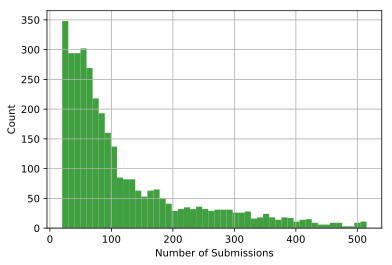

In [5]:
num_user_submissions = np.array(list(map(len, data.user_rows)))
num_user_submissions_st = 20
num_user_submissions_ed = np.percentile(num_user_submissions, 99)
print(num_user_submissions_st, num_user_submissions_ed)
n, bins, patches = plt.hist(num_user_submissions, 50, (num_user_submissions_st, num_user_submissions_ed), facecolor='g', alpha=0.75)
plt.xlabel('Number of Submissions')
plt.ylabel('Count')
plt.grid(True)
plt.show()

  0%|          | 0/515 [00:00<?, ?it/s]

user_id 1749


100%|██████████| 515/515 [01:30<00:00,  6.88it/s]


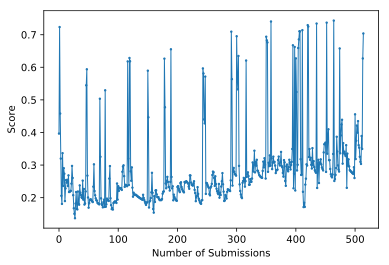

In [34]:
idxs = np.flatnonzero(((500 <= num_user_submissions) & (num_user_submissions <= 10000)))
user_id = 1749  # random.choice(idxs)
print('user_id', user_id)

x = np.empty((data.num_problems, data.lookback+1, data.data_x.shape[1]+1), dtype=np.float32)
for i, problem_id in enumerate(data.sorted_problem_ids):
    x[i, -1, data.num_user_features:-1] = data.get_problem_features(problem_id)

x_lookback = np.zeros((data.lookback, data.data_x.shape[1]+1), dtype=np.float32)
plot_ys = []
is_previous_accepted = False
for row in tqdm(data.user_rows[user_id]):
    for i in range(data.num_problems):
        x[i, :-1] = x_lookback
        x[i, -1, :data.num_user_features] = data.data_x[row, :data.num_user_features]
        x[i, -1, :-1] /= data.max_abs
        x[i, -1, -1] = is_previous_accepted
    prob = data.rnn.predict(x).squeeze()
    plot_ys.append(np.average(prob))

    x_lookback[:-1] = x_lookback[1:]
    x_lookback[-1, :-1] = data.data_x[row] / data.max_abs
    x_lookback[-1, -1] = is_previous_accepted
    is_previous_accepted = bool(data.data_y[row])

plot_xs = range(len(data.user_rows[user_id]))
plt.xlabel('Number of Submissions')
plt.ylabel('Score')
plt.plot(plot_xs, plot_ys, '.-', linewidth=1, markersize=3)
plt.savefig('data/submit-score-user-{}.pdf'.format(user_id), bbox_inches='tight')
plt.show()

  0%|          | 1/536 [00:00<01:32,  5.78it/s]

user_id 1830


100%|██████████| 536/536 [01:16<00:00,  7.69it/s]


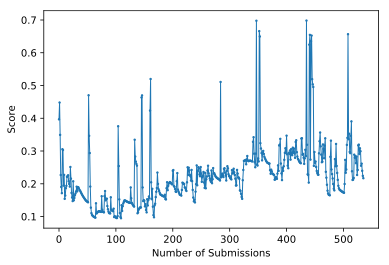

In [15]:
idxs = np.flatnonzero(((500 <= num_user_submissions) & (num_user_submissions <= 600)))
user_id = random.choice(idxs)
print('user_id', user_id)

x = np.empty((data.num_problems, data.lookback+1, data.data_x.shape[1]+1), dtype=np.float32)
for i, problem_id in enumerate(data.sorted_problem_ids):
    x[i, -1, data.num_user_features:-1] = data.get_problem_features(problem_id)

x_lookback = np.zeros((data.lookback, data.data_x.shape[1]+1), dtype=np.float32)
plot_ys = []
is_previous_accepted = False
for row in tqdm(data.user_rows[user_id]):
    for i in range(data.num_problems):
        x[i, :-1] = x_lookback
        x[i, -1, :data.num_user_features] = data.data_x[row, :data.num_user_features]
        x[i, -1, :-1] /= data.max_abs
        x[i, -1, -1] = is_previous_accepted
    prob = data.rnn.predict(x).squeeze()
    plot_ys.append(np.average(prob))

    x_lookback[:-1] = x_lookback[1:]
    x_lookback[-1, :-1] = data.data_x[row] / data.max_abs
    x_lookback[-1, -1] = is_previous_accepted
    is_previous_accepted = bool(data.data_y[row])

plot_xs = range(len(data.user_rows[user_id]))
plt.xlabel('Number of Submissions')
plt.ylabel('Score')
plt.plot(plot_xs, plot_ys, '.-', linewidth=1, markersize=3)
plt.show()

  0%|          | 1/589 [00:00<01:49,  5.37it/s]

user_id 1838


100%|██████████| 589/589 [01:28<00:00,  7.21it/s]


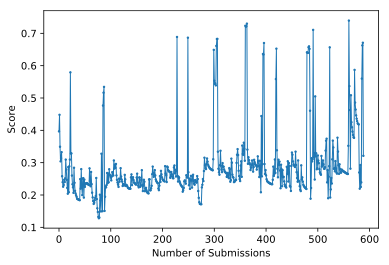

In [24]:
idxs = np.flatnonzero(((500 <= num_user_submissions) & (num_user_submissions <= 10000)))
user_id = random.choice(idxs)
print('user_id', user_id)

x = np.empty((data.num_problems, data.lookback+1, data.data_x.shape[1]+1), dtype=np.float32)
for i, problem_id in enumerate(data.sorted_problem_ids):
    x[i, -1, data.num_user_features:-1] = data.get_problem_features(problem_id)

x_lookback = np.zeros((data.lookback, data.data_x.shape[1]+1), dtype=np.float32)
plot_ys = []
is_previous_accepted = False
for row in tqdm(data.user_rows[user_id]):
    for i in range(data.num_problems):
        x[i, :-1] = x_lookback
        x[i, -1, :data.num_user_features] = data.data_x[row, :data.num_user_features]
        x[i, -1, :-1] /= data.max_abs
        x[i, -1, -1] = is_previous_accepted
    prob = data.rnn.predict(x).squeeze()
    plot_ys.append(np.average(prob))

    x_lookback[:-1] = x_lookback[1:]
    x_lookback[-1, :-1] = data.data_x[row] / data.max_abs
    x_lookback[-1, -1] = is_previous_accepted
    is_previous_accepted = bool(data.data_y[row])

plot_xs = range(len(data.user_rows[user_id]))
plt.xlabel('Number of Submissions')
plt.ylabel('Score')
plt.plot(plot_xs, plot_ys, '.-', linewidth=1, markersize=3)
plt.show()

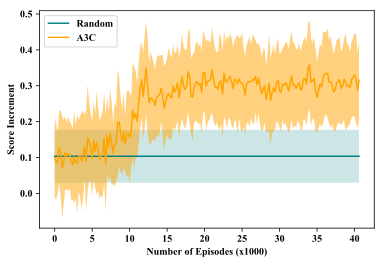

In [50]:
with open('logs/random-20180514-125155.log') as f:
    rewards = list(map(lambda l: float(l.split()[1]), f.readlines()))
random_mean = np.mean(rewards)
random_std = np.std(rewards)

with open('logs/a3c-20180514-083648.log') as f:
    rewards = list(map(lambda l: float(l.split()[1]), f.readlines()))
episodes_per_point = 200
points = len(rewards) // episodes_per_point
xs, means, stds = np.empty(points, float), np.empty(points, float), np.empty(points, float)
done = False
for i in range(points):
    rs = rewards[i*episodes_per_point : (i+1)*episodes_per_point]
    xs[i] = i * episodes_per_point / 1000
    means[i] = np.mean(rs)
    stds[i] = np.std(rs)
plt.xlabel('Number of Episodes (x1000)')
plt.ylabel('Score Increment')
plt.plot(xs, [random_mean] * len(xs), color='teal', label='Random')
plt.fill_between(xs, random_mean-random_std, random_mean+random_std, facecolor='teal', alpha=0.2)
plt.plot(xs, means, color='orange', label='A3C')
plt.fill_between(xs, means-stds, means+stds, facecolor='orange', alpha=0.5)
plt.legend(loc='upper left')
plt.savefig('data/a3c-episode-reward.pdf', bbox_inches='tight')
plt.show()    

In [14]:
init_score, last_score, greedy_score, random_score, rl_score = [], [], [], [], []
with open('data/handpick.csv') as f:
    next(f)
    for line in f:
        if not line:
            continue
        l = list(map(float, line.split(',')[1:]))
        init_score.append(l[0])
        last_score.append(l[1])
        greedy_score.append(l[2])
        random_score.append(l[3])
        rl_score.append(l[4])
init_score = np.array(init_score)
last_inc = (np.array(last_score) - init_score) / init_score * 100
greedy_inc = (np.array(greedy_score) - init_score) / init_score * 100
random_inc = (np.array(random_score) - init_score) / init_score * 100
rl_inc = (np.array(rl_score) - init_score) / init_score * 100

48 -67.80677668662621 429.839186396393


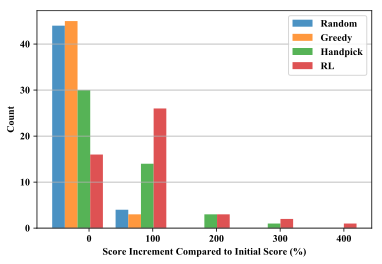

In [49]:
xmin = min(last_inc.min(), greedy_inc.min(), random_inc.min(), rl_inc.min())
xmax = max(last_inc.max(), greedy_inc.max(), random_inc.max(), rl_inc.max())
xs = [random_inc, greedy_inc, last_inc, rl_inc]
labels = ['Random', 'Greedy', 'Handpick', 'RL']
print(len(last_inc), xmin, xmax)
plt.hist(xs, 5, (xmin, xmax), label=labels, histtype='bar', rwidth=0.8, alpha=0.8)
plt.xlabel('Score Increment Compared to Initial Score (%)')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.legend(loc='upper right')
plt.savefig('data/policy-hist.pdf', bbox_inches='tight')
plt.show()